In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

SEED = 123
np.random.seed(SEED)

In [2]:
DATA_RAW_PATH = '../data/raw/'
DATA_INTER_PATH = '../data/interim/'
FIGURES = '../figures/'
MODELS = '../models/'
DATA_RAW_NAME = 'teste_smarkio_lbs.xls'
DATA_INTER_NAME = 'df_1.csv'

In [3]:
df = pd.read_csv(DATA_INTER_PATH+DATA_INTER_NAME)
df.head(7)

,Pred_class,probabilidade,status,True_class
0,2,0.079892,approved,0.0
1,2,0.379377,approved,74.0
2,2,0.379377,approved,74.0
3,2,0.420930,approved,74.0
4,2,0.607437,approved,2.0
5,2,0.690894,approved,2.0
6,2,0.759493,approved,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pred_class     643 non-null    int64  
 1   probabilidade  643 non-null    float64
 2   status         643 non-null    object 
 3   True_class     643 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 20.2+ KB


### Questão 3: 

#### Crie um classificador que tenha como output se os dados com status igual a revision estão corretos ou não (Sugestão : Técnica de cross-validation K-fold)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgbm
import xgboost as xgb
import catboost as ctb

from sklearn.model_selection import cross_validate, cross_val_score, KFold, learning_curve
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

import pickle

* input: Pred_class, probabilidade
* output: True_class

In [6]:
train = df[df['status'] == 'approved'].drop('status', axis=1)
test = df[df['status'] == 'revision'].drop('status', axis=1)

X_train = train.iloc[:,:2].values
y_train = train.iloc[:,2].values

X_test = test.iloc[:,:2].values
y_test = test.iloc[:,2].values

print('Treino:',X_train.shape, y_train.shape)
print('Teste:',X_test.shape, y_test.shape)

Treino: (600, 2) (600,)
Teste: (43, 2) (43,)


In [7]:
models = [
    ('DecisionTree', DecisionTreeClassifier(random_state=SEED)),
    ('RandomForest', RandomForestClassifier(random_state=SEED)),
    ('ExtraTree', ExtraTreesClassifier(random_state=SEED)),
    ('Adaboost', AdaBoostClassifier(random_state=SEED)),
    ('XGBoost', xgb.XGBClassifier(random_state=SEED)),
    ('LightGBM', lgbm.LGBMClassifier(random_state=SEED)),
    ('Catboost', ctb.CatBoostClassifier(random_state=SEED, verbose=False)),
    ('LogisticRegression', LogisticRegression(random_state=SEED)),
    ('SVC', SVC(random_state=SEED))
]

In [8]:
original = pd.DataFrame()

for name, model in tqdm(models):
    
    kfold = KFold(n_splits=3, random_state=SEED, shuffle=True)
    score = cross_validate(model, X_train, y_train, cv=kfold, scoring=['precision_weighted','recall_weighted','f1_weighted'], return_train_score=True)        
    additional = pd.DataFrame({
    'precision_train': np.mean(score['train_precision_weighted']),
    'precision_test' :  np.mean(score['test_precision_weighted']),
    'recall_train': np.mean(score['train_recall_weighted']),
    'recall_test' : np.mean(score['test_recall_weighted']),
    'f1_train' : np.mean(score['train_f1_weighted']),
    'f1_test' : np.mean(score['test_f1_weighted']),
    }, index=[name])

    new = pd.concat([original, additional], axis=0)
    original = new

  0%|          | 0/9 [00:00<?, ?it/s]

[18:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Questão 4:

#### Compare três métricas de avaliação aplicadas ao modelo e descreva sobre a diferença.

In [9]:
original

,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
DecisionTree,0.997536,0.593028,0.997500,0.593333,0.997498,0.573649
RandomForest,0.997557,0.539982,0.997500,0.553333,0.997486,0.525923
ExtraTree,0.997536,0.546556,0.997500,0.561667,0.997498,0.533728
Adaboost,0.110871,0.118734,0.222500,0.225000,0.124007,0.128146
XGBoost,0.982366,0.619289,0.988333,0.633333,0.984853,0.605545
LightGBM,0.984414,0.590629,0.983333,0.610000,0.982171,0.580296
Catboost,0.973669,0.572989,0.973333,0.593333,0.972207,0.559784
LogisticRegression,0.105122,0.055064,0.215000,0.185000,0.105144,0.075540
SVC,0.104726,0.092244,0.270833,0.241667,0.148538,0.129543


Como escolher uma dessas métricas?

Dependeria do problema em si do negócio. 
- Caso os falsos positivos impactassem mais no négocio a escolha seria: *precision*.
- Caso os falsos negativos tivessem maior impacto: *recall*.
- Caso em que o négocio precisa de um equilíbrio entre essas duas métricas citadas acima: *f1-score*.

Como existe um equilíbrio entre *Precision* e *Recall* nesse caso, irei avaliar *f1-Score*.


Podemos perceber um possível problema com *overfitting*. O modelo está se saindo muito bem no treino, porém no teste não.

In [10]:
model = xgb.XGBClassifier(random_state=SEED)

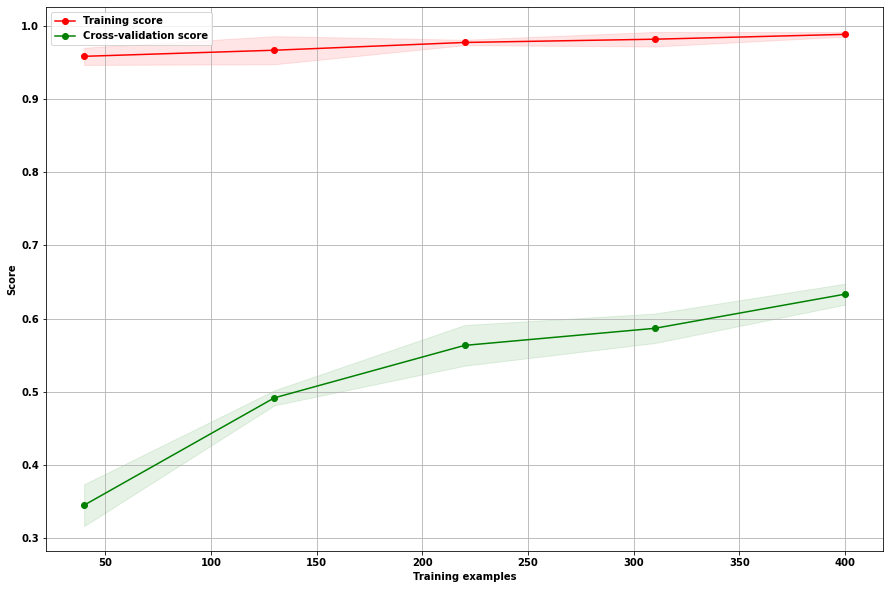

In [11]:
train_sizes, train_scores, test_scores= learning_curve(model, X_train, y_train, cv=kfold, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize=(15, 10))

ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

ax.legend(loc="best")
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")

fig.savefig(FIGURES+'/learning_curve.png')

Enfrentamos um problema de *overfitting*

  0%|          | 0/9 [00:00<?, ?it/s]

[18:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


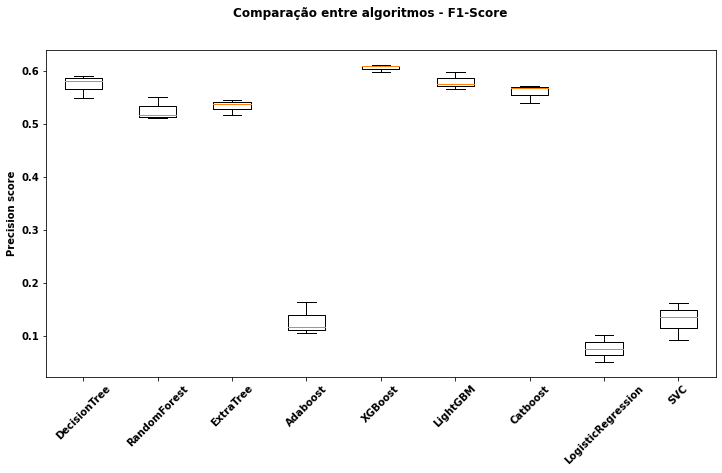

In [12]:
results = []
names = []

for name, model in tqdm(models):
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=('f1_weighted'))
    results.append(cv_results)
    names.append(name)

fig = plt.figure(figsize=(12,6))
fig.suptitle('Comparação entre algoritmos - F1-Score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('Precision score')
plt.xticks(rotation=45)
plt.grid(b=False)
plt.show()

fig.savefig(FIGURES+'/comparacao-modelos.png')

Como existem várias *classes* na previsão, utilizo todas as métricas com *'_weighted'*, assim consigo, com base na proporção da *classe* que está sendo prevista, colocar um ponderar/colocar um peso sobre essa *classe*.

Modelo selecionado: *XGBoost*

#### Predict

In [13]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         3
         3.0       0.27      1.00      0.43         3
         4.0       0.00      0.00      0.00         3
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        17.0       0.00      0.00      0.00         1
        22.0       0.00      0.00      0.00         1
        24.0       0.00      0.00      0.00         5
        25.0       0.00      0.00      0.00         3
        32.0       0.00      0.00      0.00         1
        36.0       0.00      0.00      0.00         1
        39.0       0.00      0.00      0.00         2
        43.0       0.00      0.00      0.00         2
        55.0       0.00      0.00      0.00         2
        60.0       0.00      0.00      0.00         4
        74.0       0.00      0.00      0.00         0
        77.0       0.00    

Modelo conseguiu acertar 56% dos dados que estavam em *revision*.

In [14]:
pickle.dump(model, open(MODELS+'modelo_classificador.sav', 'wb'))

Exportação do modelo.